<a href="https://colab.research.google.com/github/Vas1l1sa/Bioinformatics-ML-petproject/blob/main/C%D0%BE%D0%B7%D0%B4%D0%B0%D0%BD%D0%B8%D0%B5_%D0%BC%D0%BE%D0%B4%D0%B5%D0%BB%D0%B8_ML_Bioinformatics_%2B_ML_petproject_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn


In [ ]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from sklearn.exceptions import FitFailedWarning
warnings.simplefilter("ignore", FitFailedWarning)


### Как разделить здоровых людей и людей с гастритом на основании различий в их микробиоте кишечника?



**Будем осуществлять supervised learning для задачи классификации с использованием следующих моделей машинного обучения:**

**1.   Логистическая регрессия**

**2.   KNN**

**3.   SVM**

**4.   Базовые деревья решений**

**5.   Random forests**

**6.   Boosting и AdaBoosting**

**7.   Градиентный бустинг**






###**1. Общая подготовка данных перед машинным обучением**

In [ ]:
#загрузим полученные ранее датасеты
df = pd.read_csv('/content/drive/MyDrive/данные для петпроджекта/df.csv')
df_healthy = pd.read_csv('/content/drive/MyDrive/данные для петпроджекта/df_healthy.csv')
df_total = pd.read_csv('/content/drive/MyDrive/данные для петпроджекта/df_total.csv')

In [ ]:
len(df_total)

274

In [ ]:
#разделим данные на признаки и отклик

X = df_total.drop(['Index'], axis=1)
y = df_total['Index']


**В данной задаче нормировка признаков не требуется, т.к. все данные в датасете - процентное содержание того или иного вида в образце, т.е. по сути они уже отнормированы**

In [ ]:
#посмотрим корреляцию признаков и отклика (какие признаки больше других влияют на отклик)

np.abs(df_total.corr()['Index']).sort_values(ascending=False).drop('Index').head(10)


,Index
Faecalibacterium_prausnitzii,0.699834
Bacteroides_vulgatus,0.417186
Bacteroides_dorei/vulgatus,0.411259
Phascolarctobacterium_faecium,0.408868
Parabacteroides_merdae,0.397475
Lachnospira_pectinoschiza,0.367726
Bacteroides_uniformis,0.363811
Collinsella_aerofaciens,0.350600
Faecalibacterium_cf./prausnitzii,0.346576
Alistipes_putredinis,0.330995


**Ввиду того, что датасет получился довольно маленьким, сделаем разбивку данных только на обучающую и тестовую выборки (без hold-out test set).**

**Для подбора оптимальных гиперпараметров будем применять кросс-валидацию (GridSearchCV) для тестовой выборки, т.к. от изменения разбивки данных результаты ошибок тоже будут меняться.**

In [ ]:
#разделим данные на тренировочную и тестовую выборки

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


###**2. Создание модели бинарной классификации на основе алгоритма логистической регрессии**


In [ ]:
#создадим модель логистической регрессии и подберем оптимальные гиперпараметры при помощи поиска по сетке и кросс-валидации

from sklearn.linear_model import LogisticRegressionCV
test_model1 = LogisticRegressionCV(cv = 5, max_iter = 50000, random_state=42) #устанавливаем параметр random_state, чтобы при нескольких запусках GridSearchCV со скорректированным списком гиперпараметров результаты получались уточненными, а не совершенно новыми


In [ ]:
#посмотрим информацию по гиперпараметрам этого алгоритма и на основании нее составим словарь parem_grid
#help(LogisticRegressionCV())

In [ ]:
#сделаем поиск по сетке для нахождения оптимальных гиперпараметров

from sklearn.model_selection import GridSearchCV
param_grid1 = [
    {'Cs': [1, 2, 3], 'solver': ['lbfgs', 'newton-cg', 'sag', 'saga'], 'dual': [False]},
    {'Cs': [1, 2, 3], 'solver': ['liblinear'], 'dual': [True, False]},
]
#разбила param_grid1 на 2 части, чтобы не выпадали ошибки при переборе некоторых комбинаций solver и dual
grid1 = GridSearchCV(test_model1, param_grid1, error_score=np.nan)

grid1.fit(X_train, y_train)
grid1.best_params_

{'Cs': 3, 'dual': False, 'solver': 'sag'}

In [ ]:
#создадим модель с найденными оптимальными гиперпараметрами
logistic_regression_model = LogisticRegressionCV(cv = 5, max_iter = 50000, Cs = 3, dual=False, solver='sag')
logistic_regression_model.fit(X_train, y_train)
y_pred1 = logistic_regression_model.predict(X_test)
y_pred1

array([0., 1., 0., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1.,
       0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0.,
       1., 1., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0.,
       1., 0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 0., 0., 1.])

###**3. Создание модели бинарной классификации на основе алгоритма KNN**

In [ ]:
#создадим модель логистической регрессии и подберем оптимальные гиперпараметры при помощи поиска по сетке и кросс-валидации
from sklearn.neighbors import KNeighborsClassifier
test_model2 = KNeighborsClassifier()

In [ ]:
#help(KNeighborsClassifier)

In [ ]:
#сделаем поиск по сетке для нахождения оптимальных гиперпараметров
from sklearn.model_selection import GridSearchCV

param_grid2 = {'n_neighbors': list(range(1,20))}

grid2 = GridSearchCV(test_model2, param_grid2, cv=5, scoring='accuracy')
grid2.fit(X_train, y_train)
grid2.best_params_
#{'n_neighbors': 1}

{'n_neighbors': 1}

In [ ]:
#создадим модель с найденными оптимальными гиперпараметрами
knn_model = KNeighborsClassifier(n_neighbors=1)
knn_model.fit(X_train, y_train)
y_pred2 = knn_model.predict(X_test)
y_pred2

array([0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
       0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0.,
       1., 1., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0.,
       1., 0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0.])

###**4. Создание модели бинарной классификации на основе алгоритма SVM**

In [ ]:
#создадим модель логистической регрессии и подберем оптимальные гиперпараметры при помощи поиска по сетке и кросс-валидации
from sklearn.svm import SVC
test_model3 = SVC()



In [ ]:
#help(SVC)

In [ ]:
#сделаем поиск по сетке для нахождения оптимальных гиперпараметров
from sklearn.model_selection import GridSearchCV

param_grid3 = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'C': [0.01, 0.1, 1, 1.2, 1.4, 1.45, 1.46, 1.465, 1.47, 1.475, 1.48, 1.5, 1.52, 1.55, 1.7, 2, 5, 10, 15, 20, 25, 30]}

grid3 = GridSearchCV(test_model3, cv=5, param_grid = param_grid3, scoring='accuracy')
grid3.fit(X_train, y_train)
grid3.best_params_
#когда мы получили какое-то предварительно хорошее значение 'C', потом обязательно добавляем в список для перебора ближайшие к этому числу значения и запускаем повторный поиск по сетке

{'C': 1.465, 'kernel': 'sigmoid'}

In [ ]:
#создадим модель с найденными оптимальными гиперпараметрами
svm_model = SVC(C=1.465, kernel='sigmoid')
svm_model.fit(X_train, y_train)
y_pred3 = svm_model.predict(X_test)
y_pred3

array([0., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
       0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0.,
       1., 1., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0.,
       1., 0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 0., 0., 1.])

###**5. Создание модели бинарной классификации на основе алгоритма базовых деревьев решений**

In [ ]:
#создадим модель логистической регрессии и подберем оптимальные гиперпараметры при помощи поиска по сетке и кросс-валидации
from sklearn.tree import DecisionTreeClassifier
test_model4 = DecisionTreeClassifier(random_state=42) #устанавливаем параметр random_state, чтобы при нескольких запусках GridSearchCV со скорректированным списком гиперпараметров результаты получались уточненными, а не совершенно новыми


In [ ]:
#help(DecisionTreeClassifier())

In [ ]:
#сделаем поиск по сетке для нахождения оптимальных гиперпараметров
from sklearn.model_selection import GridSearchCV
param_grid4 = {'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'criterion': ["gini", "entropy", "log_loss"]}
grid4 = GridSearchCV(test_model4, param_grid4, cv=5, scoring='accuracy')
grid4.fit(X_train, y_train)
grid4.best_params_

{'criterion': 'gini', 'max_depth': 2}

In [ ]:
#создадим модель с найденными оптимальными гиперпараметрами
decision_tree_model = DecisionTreeClassifier(criterion='gini', max_depth=2)
decision_tree_model.fit(X_train, y_train)
y_pred4 = decision_tree_model.predict(X_test)
y_pred4

array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1.,
       0., 0., 1., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0.,
       1., 1., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0.,
       1., 0., 0., 1., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0.])

###**6. Создание модели бинарной классификации на основе алгоритма Random forests**

In [ ]:
#создадим модель логистической регрессии и подберем оптимальные гиперпараметры при помощи поиска по сетке и кросс-валидации
from sklearn.ensemble import RandomForestClassifier
test_model5 = RandomForestClassifier(random_state=42) #устанавливаем параметр random_state, чтобы при нескольких запусках GridSearchCV со скорректированным списком гиперпараметров результаты получались уточненными, а не совершенно новыми

In [ ]:
#help(RandomForestClassifier())

In [ ]:
#сделаем поиск по сетке для нахождения оптимальных гиперпараметров
from sklearn.model_selection import GridSearchCV
param_grid5 = {'n_estimators': [5, 6, 7, 8, 9, 10, 12, 15, 20, 30, 40, 45, 50, 55, 60, 65, 70, 75, 80, 90, 100, 120, 140, 200, 300, 400, 500], 'max_features': ['sqrt', 'log2']}
grid5 = GridSearchCV(test_model5, param_grid5, cv=5, scoring='accuracy', error_score=np.nan)
grid5.fit(X_train, y_train)
grid5.best_params_
#когда мы получили какое-то предварительно хорошее значение 'n_estimators', потом обязательно добавляем в список для перебора ближайшие к этому числу значения и запускаем повторный поиск по сетке


{'max_features': 'sqrt', 'n_estimators': 8}

In [ ]:
#создадим модель с найденными оптимальными гиперпараметрами
random_forest_model = RandomForestClassifier(max_features='sqrt', n_estimators=8)
random_forest_model.fit(X_train, y_train)
y_pred5 = random_forest_model.predict(X_test)
y_pred5

array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1.,
       0., 0., 1., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0.,
       1., 1., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0.,
       1., 0., 0., 1., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1.])

###**7. Создание модели бинарной классификации на основе алгоритма Boosting и AdaBoosting**

In [ ]:
#создадим модель логистической регрессии и подберем оптимальные гиперпараметры при помощи поиска по сетке и кросс-валидации
from sklearn.ensemble import AdaBoostClassifier
test_model6 = AdaBoostClassifier()


In [ ]:
#help(AdaBoostClassifier())

In [ ]:
#сделаем поиск по сетке для нахождения оптимальных гиперпараметров
from sklearn.model_selection import GridSearchCV

param_grid6 = {'n_estimators': [5, 7, 8, 9, 10, 11, 12, 15, 20, 30, 40, 50, 60, 70, 80, 90, 100, 120, 150]}

grid6 = GridSearchCV(test_model6, param_grid6, cv=5, scoring='accuracy')
grid6.fit(X_train, y_train)
grid6.best_params_

{'n_estimators': 10}

In [ ]:
#создадим модель с найденными оптимальными гиперпараметрами
ada_boosting_model = AdaBoostClassifier(n_estimators=10)
ada_boosting_model.fit(X_train, y_train)
y_pred6 = ada_boosting_model.predict(X_test)
y_pred6

array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1.,
       0., 0., 1., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0.,
       1., 1., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0.,
       1., 0., 0., 1., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0.])

###**8. Создание модели бинарной классификации на основе алгоритма градиентного бустинга**

In [ ]:
#создадим модель логистической регрессии и подберем оптимальные гиперпараметры при помощи поиска по сетке и кросс-валидации

from sklearn.ensemble import GradientBoostingClassifier
test_model7 = GradientBoostingClassifier(random_state=42) #устанавливаем параметр random_state, чтобы при нескольких запусках GridSearchCV со скорректированным списком гиперпараметров результаты получались уточненными, а не совершенно новыми


In [ ]:
#help(GradientBoostingClassifier())

In [ ]:
#сделаем поиск по сетке для нахождения оптимальных гиперпараметров
from sklearn.model_selection import GridSearchCV
#param_grid7 = {'n_estimators': [10, 30, 50, 90, 100, 115, 118, 119, 120, 121, 122, 125, 150], 'learning_rate': [0.0005, 0.001, 0.0015, 0.002, 0.005, 0.01], 'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12], 'max_features' : ['None', 'sqrt', 'log2'], 'loss' : ['log_loss', 'exponential']}
param_grid7 = {'n_estimators': [118, 119, 120, 121, 122, 125], 'learning_rate': [0.0005, 0.001, 0.0015, 0.002], 'max_depth': [8, 9, 10, 11, 12], 'max_features' : ['log2'], 'loss' : ['exponential']}
grid7 = GridSearchCV(test_model7, param_grid7, cv=5, scoring='accuracy')
grid7.fit(X_train, y_train)
grid7.best_params_

{'learning_rate': 0.001,
 'loss': 'exponential',
 'max_depth': 10,
 'max_features': 'log2',
 'n_estimators': 120}

In [ ]:
#создадим модель с найденными оптимальными гиперпараметрами
gradient_boosting_model = GradientBoostingClassifier(learning_rate=0.001, loss='exponential', max_depth=10, max_features='log2', n_estimators=120)
gradient_boosting_model.fit(X_train, y_train)
y_pred7 = gradient_boosting_model.predict(X_test)
y_pred7

array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1.,
       0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0.,
       1., 1., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0.,
       1., 0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 0., 0., 1.])

###**9. Напишем функцию для сранения всех этих моделей между собой**

Evaluating model: LogisticRegressionCV
Accuracy: 0.963855421686747


              precision    recall  f1-score   support

         0.0       0.95      0.98      0.97        43
         1.0       0.97      0.95      0.96        40

    accuracy                           0.96        83
   macro avg       0.96      0.96      0.96        83
weighted avg       0.96      0.96      0.96        83



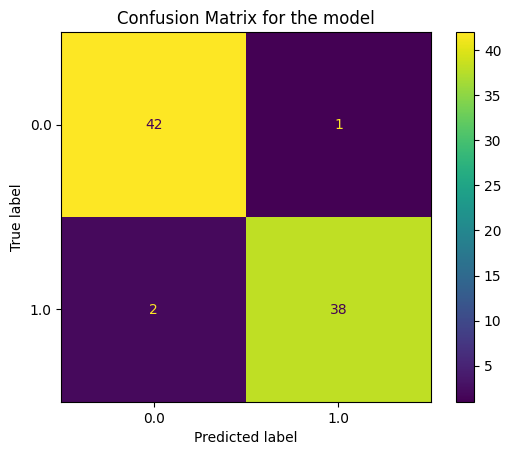



Evaluating model: KNeighborsClassifier
Accuracy: 0.9036144578313253


              precision    recall  f1-score   support

         0.0       0.86      0.98      0.91        43
         1.0       0.97      0.82      0.89        40

    accuracy                           0.90        83
   macro avg       0.91      0.90      0.90        83
weighted avg       0.91      0.90      0.90        83



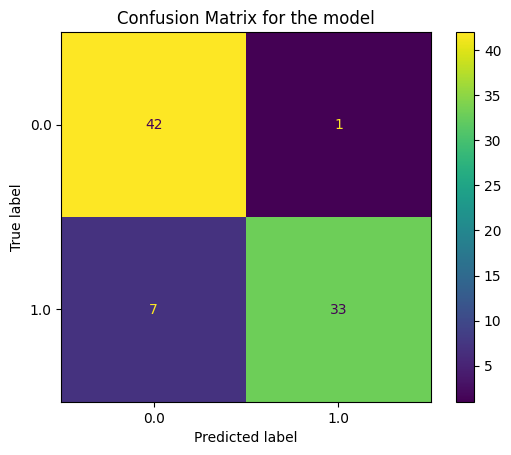



Evaluating model: SVC
Accuracy: 0.9397590361445783


              precision    recall  f1-score   support

         0.0       0.95      0.93      0.94        43
         1.0       0.93      0.95      0.94        40

    accuracy                           0.94        83
   macro avg       0.94      0.94      0.94        83
weighted avg       0.94      0.94      0.94        83



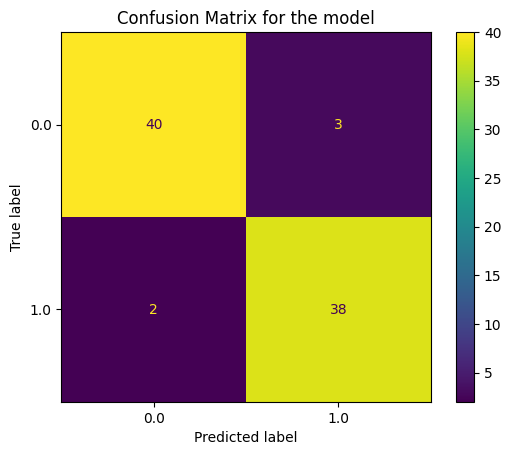



Evaluating model: DecisionTreeClassifier
Accuracy: 0.9518072289156626


              precision    recall  f1-score   support

         0.0       0.93      0.98      0.95        43
         1.0       0.97      0.93      0.95        40

    accuracy                           0.95        83
   macro avg       0.95      0.95      0.95        83
weighted avg       0.95      0.95      0.95        83



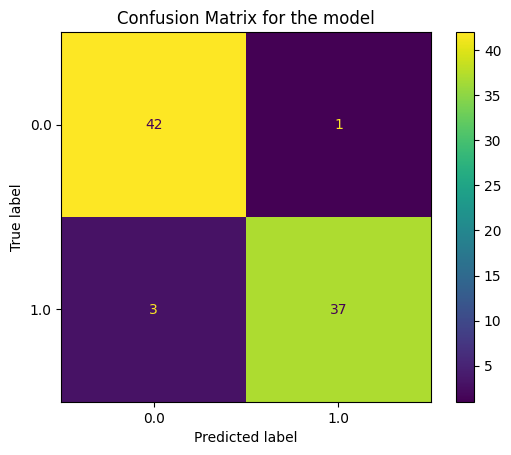



Evaluating model: RandomForestClassifier
Accuracy: 0.9759036144578314


              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98        43
         1.0       0.97      0.97      0.97        40

    accuracy                           0.98        83
   macro avg       0.98      0.98      0.98        83
weighted avg       0.98      0.98      0.98        83



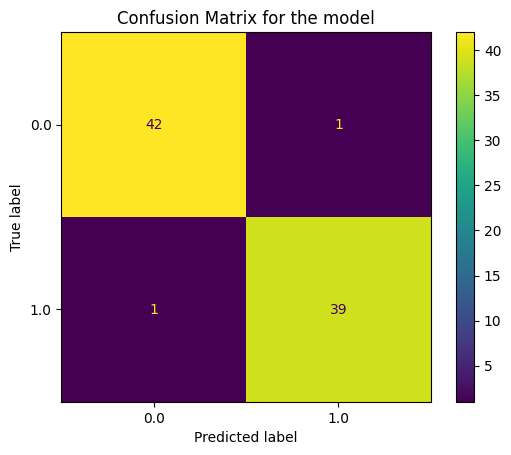



Evaluating model: AdaBoostClassifier
Accuracy: 0.963855421686747


              precision    recall  f1-score   support

         0.0       0.93      1.00      0.97        43
         1.0       1.00      0.93      0.96        40

    accuracy                           0.96        83
   macro avg       0.97      0.96      0.96        83
weighted avg       0.97      0.96      0.96        83



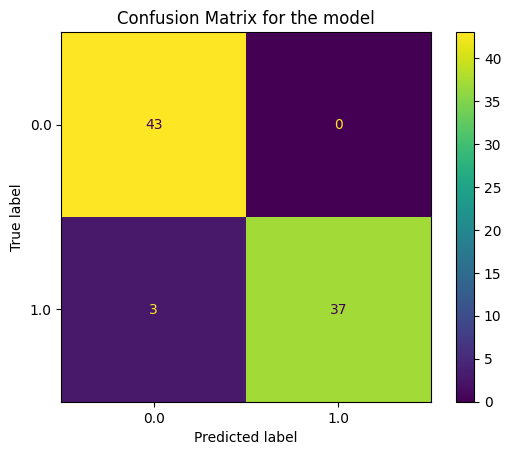



Evaluating model: GradientBoostingClassifier
Accuracy: 0.9879518072289156


              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99        43
         1.0       1.00      0.97      0.99        40

    accuracy                           0.99        83
   macro avg       0.99      0.99      0.99        83
weighted avg       0.99      0.99      0.99        83



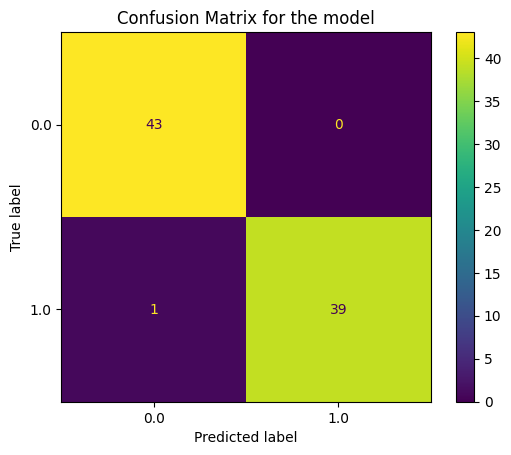

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

def run_models(models, X_train, y_train, X_test, y_test):
    for model in models:
        print(f"Evaluating model: {model.__class__.__name__}")

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Вычисление метрик
        accuracy = accuracy_score(y_test, y_pred)

        # Вывод метрик
        print(f'Accuracy: {accuracy}')
        print('\n')
        print(classification_report(y_test, y_pred))

        # Построение матрицы ошибок

        ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)
        plt.title('Confusion Matrix for the model')
        plt.show()

        print('\n')

# Пример использования:
models = [logistic_regression_model, knn_model, svm_model, decision_tree_model, random_forest_model, ada_boosting_model, gradient_boosting_model]

run_models(models, X_train, y_train, X_test, y_test)


###**10. Напишем функцию для выбора наилучшей модели машинного обучения для этой задачи**

**Выберем модель, которая показала наилучшие результаты. В нашем датасете классы сбалансированы, поэтому для оценки моделей можно смотреть на показатель accuracy**

In [ ]:
#посмотрим, у какой из воделей наилучшая метрика accuracy
def best_accuracy(models, X_train, y_train, X_test, y_test):
    best_accuracy = 0
    best_model_by_accuracy = None

    for model in models:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model_by_accuracy = model
    print(f"Best model by accuracy: {best_model_by_accuracy.__class__.__name__} with accuracy: {best_accuracy}")



models = [logistic_regression_model, knn_model, svm_model, decision_tree_model, random_forest_model, ada_boosting_model, gradient_boosting_model]
best_accuracy(models, X_train, y_train, X_test, y_test)

Best model by accuracy: GradientBoostingClassifier with accuracy: 0.9879518072289156


**Таким образом, модель gradient_boosting_model (GradientBoostingClassifier ()) с подобранными гиперпараметрами оказалась наилучшей**

###**11. Посмотрим на лучшую модель отдельно**

Метрики для gradient_boosting_model
Accuracy: 0.9879518072289156


              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99        43
         1.0       1.00      0.97      0.99        40

    accuracy                           0.99        83
   macro avg       0.99      0.99      0.99        83
weighted avg       0.99      0.99      0.99        83



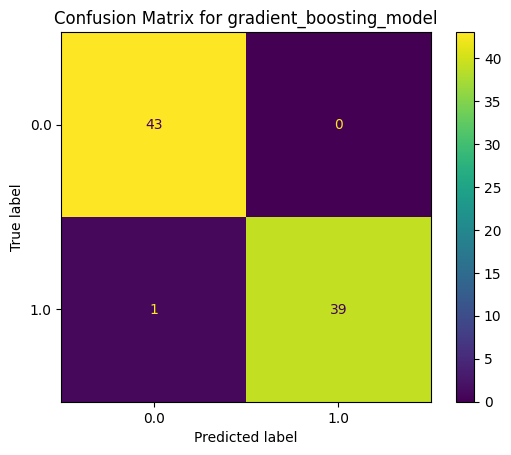

In [ ]:
gradient_boosting_model.fit(X_train, y_train)
y_pred = gradient_boosting_model.predict(X_test)

# Вычисление метрик
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

# Вывод метрик
print('Метрики для gradient_boosting_model')
print(f'Accuracy: {accuracy}')
print('\n')
print(classification_report(y_test, y_pred))

# Построение матрицы ошибок

ConfusionMatrixDisplay.from_estimator(gradient_boosting_model, X_test, y_test)
plt.title('Confusion Matrix for gradient_boosting_model')
plt.show()

###**12. Проверим, нет ли переобучения у нашей модели, т.к. метрики показывают довольно высокие значения**

In [ ]:
#посморим на лучший средний результат accuracy на кросс-валидации на обучающей выборке
best_cv_score = grid7.best_score_
print(f'Лучший средний результат на кросс-валидации (accuracy): {best_cv_score}')

Лучший средний результат на кросс-валидации (accuracy): 1.0


In [ ]:
#посморим на метрики accuracy и др. на тестовой выборке
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_pred_test = gradient_boosting_model.predict(X_test)


test_accuracy = accuracy_score(y_test, y_pred_test)
test_precision = precision_score(y_test, y_pred_test)
test_recall = recall_score(y_test, y_pred_test)
test_f1 = f1_score(y_test, y_pred_test)

print(f'Точность (accuracy) на тестовой выборке: {test_accuracy}')
print(f'Точность (precision) на тестовой выборке: {test_precision}')
print(f'Полнота (recall) на тестовой выборке: {test_recall}')
print(f'F1-метрика на тестовой выборке: {test_f1}')

Точность (accuracy) на тестовой выборке: 0.9879518072289156
Точность (precision) на тестовой выборке: 1.0
Полнота (recall) на тестовой выборке: 0.975
F1-метрика на тестовой выборке: 0.9873417721518988


**Интерпретация метрик и их анализ на предмет переобучения**


Точность 1.0 на кросс-валидации говорит о том, что модель очень хорошо обучилась на данных из обучающей выборки.

На тестовой выборке точность составляет 0.9879, а F1-метрика — 0.9873, что всего лишь немного ниже, чем результаты кросс-валидации.
Precision и recall также достаточно высоки и близки к результатам на обучении. Это говорит о том, что модель не сильно потеряла в качестве на данных, которых она ранее не видела.

Обычно при переобучении модель показывает существенно лучшие результаты на кросс-валидации или обучающей выборке, чем на тестовых данных.
Здесь же расхождение метрик минимальное (разница в точности менее 1.2%), что указывает на то, что модель хорошо справляется и с новыми данными.

Таким образом, переобучение, вероятно, отсутствует.
Высокие значения всех метрик указывают на хороший подбор всех гиперпараметров и хорошее обучение модели - модель можно считать хорошо настроенной.

###**13. Отдельно посмотрим на данные, которые модель классифицировала неверно**

In [ ]:
#индексы ложнопредсказанных точек
false_predictions = np.where(y_pred != y_test)[0] #получим массив индексов таких точек
false_predictions
#найдем строки с тамики индексами в нашем датасете
false_row = df_total.iloc[false_predictions]
false_row

NameError: name 'np' is not defined

In [ ]:
#проверим, есть ли вообще в колонках ненулевые значения
false_row.sum(axis=1)
1.50853

In [ ]:
#посотрим, это значение одного признака или сумма значений нескольких признаков
df_total.columns[false_row.isin([1.50853]).any()]

Index(['Fusobacterium_nucleatum'], dtype='object')

**Почему данный образец был ошибочно классифицирован?** Как мы видим, данная строка содержит числовые значения всего одного признака из 131, что дает слишком мало информации об исследуемом образце для корректной работы модели.

###**14. Сохраним нашу модель**

In [ ]:
gastr_or_healthy_classification_model = gradient_boosting_model

In [ ]:
#сохранение модели

from joblib import dump, load

dump(gastr_or_healthy_classification_model, '/content/drive/MyDrive/данные для петпроджекта/gastr_or_healthy_classification_model.joblib')


['/content/drive/MyDrive/данные для петпроджекта/gastr_or_healthy_classification_model.joblib']

###**15. Определим, какие виды бактерий больше всего влияют на результат классификации и на основе этой информации создадим шаблон для загрузки новых данных в нашу модель**

In [ ]:
#посмотрим корреляцию признаков и отклика (какие признаки больше других влияют на отклик)

corr_ser = np.abs(df_total.corr()['Index']).sort_values(ascending=False).drop('Index')
corr_ser = pd.DataFrame(corr_ser)
col_names = corr_ser.index.tolist()
col_names

['Faecalibacterium_prausnitzii',
 'Bacteroides_vulgatus',
 'Bacteroides_dorei/vulgatus',
 'Phascolarctobacterium_faecium',
 'Parabacteroides_merdae',
 'Lachnospira_pectinoschiza',
 'Bacteroides_uniformis',
 'Collinsella_aerofaciens',
 'Faecalibacterium_cf./prausnitzii',
 'Alistipes_putredinis',
 'Alistipes_finegoldii/onderdonkii',
 'Akkermansia_muciniphila',
 'Erysipelotrichaceae_UCG-003_bacterium',
 'Desulfovibrio_piger',
 'Bifidobacterium_adolescentis/faecale/stercoris',
 'Bacteroides_caccae',
 'Parasutterella_excrementihominis',
 'Bifidobacterium_longum',
 'Sutterella_wadsworthensis',
 'Prevotella_copri',
 'Dialister_invisus',
 'Bacteroides_cellulosilyticus/intestinalis',
 'Bacteroides_fragilis',
 'Bacteroides_massiliensis',
 'Lachnospiraceae_NK4A136_group_bacterium',
 'Bacteroides_fragilis/ovatus',
 'Fusobacterium_nucleatum',
 'Escherichia/Shigella_albertii/boydii/coli/dysenteriae/fergusonii/flexneri/marmotae/sonnei',
 'Alistipes_inops',
 'Parabacteroides_distasonis',
 'Fusicatenib

In [ ]:
#создаем шаблон датафрейма, в самом начале которого располагаются самые важные поля для заполнения (они больше всего влияют на результат)
new_data = pd.DataFrame()
for i in col_names:
  new_data1 = pd.DataFrame(({i: [ ]}))
  new_data = pd.concat([new_data, new_data1], axis=1)
new_data

#сохраним датафрейм
new_data.to_excel('/content/drive/MyDrive/данные для петпроджекта/шаблон для загрузки новых данных.xlsx')
